In [1]:
import os.path as osp
import openslide
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
# 이부분 python 에서는 뺴주기

from skimage.filters import threshold_otsu
from openslide.deepzoom import DeepZoomGenerator
import cv2
from keras.utils.np_utils import to_categorical

# network
from keras.models import Sequential
from keras.layers import Lambda, Dropout
from keras.layers.convolutional import Convolution2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.models import load_model

# Unet
import numpy as np 
import os

import skimage.transform as trans
#import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


# train

from sklearn.model_selection import StratifiedShuffleSplit
from datetime import datetime

# evaluate
import matplotlib.gridspec as gridspec
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

import math
from PIL import Image
from xml.etree.ElementTree import ElementTree, Element, SubElement
from io import BytesIO
import skimage.io as io

from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())
import keras.backend.tensorflow_backend as K
from sklearn import metrics

PATCH_SIZE = 256
IS_TRAIN = True
def find_patches_from_slide(slide_path, truth_path, patch_size=PATCH_SIZE,filter_non_tissue=True,filter_only_all_tumor=True):
    
    slide_contains_tumor = 'pos' in slide_path
    
    ############### read_region을 위한 start, level, size를 구함 #######################
    BOUNDS_OFFSET_PROPS = (openslide.PROPERTY_NAME_BOUNDS_X, openslide.PROPERTY_NAME_BOUNDS_Y)
    BOUNDS_SIZE_PROPS = (openslide.PROPERTY_NAME_BOUNDS_WIDTH, openslide.PROPERTY_NAME_BOUNDS_HEIGHT)

    if slide_contains_tumor:
        with openslide.open_slide(slide_path) as slide:
            start = (int(slide.properties.get('openslide.bounds-x',0)),int(slide.properties.get('openslide.bounds-y',0)))
            level = np.log2(patch_size) 
            level = int(level)
            
            size_scale = tuple(int(slide.properties.get(prop, l0_lim)) / l0_lim
                            for prop, l0_lim in zip(BOUNDS_SIZE_PROPS,
                            slide.dimensions))
            _l_dimensions = tuple(tuple(int(math.ceil(l_lim * scale))
                            for l_lim, scale in zip(l_size, size_scale))
                            for l_size in slide.level_dimensions)
            size = _l_dimensions[level]
            
            slide4 = slide.read_region(start,level,size) 
    else :
        with openslide.open_slide(slide_path) as slide:
            start = (0,0)
            level = np.log2(patch_size) 
            level = int(level)
            
            size_scale = (1,1)
            _l_dimensions = tuple(tuple(int(math.ceil(l_lim * scale))
                            for l_lim, scale in zip(l_size, size_scale))
                            for l_size in slide.level_dimensions)
            size = _l_dimensions[level]
            
            slide4 = slide.read_region(start,level,size) 
    ####################################################################################
    
    
    # is_tissue 부분 
    slide4_grey = np.array(slide4.convert('L'))
    binary = slide4_grey > 0  # black이면 0임
    
    # 검은색 제외하고 흰색영역(배경이라고 여겨지는)에 대해서도 작업해주어야함.
    slide4_not_black = slide4_grey[slide4_grey>0]
    thresh = threshold_otsu(slide4_not_black)
    
    I, J = slide4_grey.shape
    for i in range(I):
        for j in range(J):
            if slide4_grey[i,j] > thresh :
                binary[i,j] = False
    patches = pd.DataFrame(pd.DataFrame(binary).stack())
    patches['is_tissue'] = patches[0]
    patches.drop(0, axis=1,inplace =True)
    patches.loc[:,'slide_path'] = slide_path

    # is_tumor 부분
    if slide_contains_tumor:
        with openslide.open_slide(truth_path) as truth:
            thumbnail_truth = truth.get_thumbnail(size) 
        
        patches_y = pd.DataFrame(pd.DataFrame(np.array(thumbnail_truth.convert("L"))).stack())
        patches_y['is_tumor'] = patches_y[0] > 0
        
        # mask된 영역이 애매할 수도 있으므로
        patches_y['is_all_tumor'] = patches_y[0] == 255
        patches_y.drop(0, axis=1, inplace=True)
        samples = pd.concat([patches, patches_y], axis=1) #len(samples)
    else:
        samples = patches
        #dfmi.loc[:,('one','second')] = value
        samples.loc[:,'is_tumor'] = False
        samples.loc[:,'is_all_tumor'] = False
    
    if filter_non_tissue:
        samples = samples[samples.is_tissue == True] # remove patches with no tissue #samples = samples[samples.is_tissue == True]
    
    if filter_only_all_tumor :
        samples['tile_loc'] = list(samples.index)
        all_tissue_samples1 = samples[samples.is_tumor==False]
        all_tissue_samples1 = all_tissue_samples1.append(samples[samples.is_all_tumor==True])
        
        all_tissue_samples1.reset_index(inplace=True, drop=True)
    else :
        return samples
    
    return all_tissue_samples1


NUM_CLASSES = 2 # not_tumor, tumor

def gen_imgs(all_image_path, all_mask_path, samples, batch_size, patch_size = PATCH_SIZE, shuffle=True):
   
    num_samples = len(samples)
    # 특정 몇개의 slide만 open 해서 쓰기
    # 4개씩 묶었으니까 
  
    slide_path0 = all_image_path[0]
    slide_path1 = all_image_path[1]
    slide_path2 = all_image_path[2]
    slide_path3 = all_image_path[3]
    
    
    # slide 0~3 까지 미리 열어두기
    slide0 = openslide.open_slide(slide_path0)
    slide1 = openslide.open_slide(slide_path1)
    slide2 = openslide.open_slide(slide_path2)
    slide3 = openslide.open_slide(slide_path3)
    
    # with openslide.open_slide(slide_path) as slide
    tiles0 = DeepZoomGenerator(slide0,tile_size=patch_size, overlap=0, limit_bounds=False) 
    tiles1 = DeepZoomGenerator(slide1,tile_size=patch_size, overlap=0, limit_bounds=False)
    tiles2 = DeepZoomGenerator(slide2,tile_size=patch_size, overlap=0, limit_bounds=False)
    tiles3 = DeepZoomGenerator(slide3,tile_size=patch_size, overlap=0, limit_bounds=False)
    
    if 'pos' in slide_path0:
        start_x0 = int(slide0.properties.get('openslide.bounds-x',0))
        start_y0 = int(slide0.properties.get('openslide.bounds-y',0))
        start_x0 = start_x0 / patch_size
        start_y0 = start_y0 / patch_size
        
        truth0 = openslide.open_slide(all_mask_path[0])
        truth_tiles0 = DeepZoomGenerator(truth0, tile_size=16, overlap=0, limit_bounds=False) 
        
    else : 
        start_x0 = 0
        start_y0 = 0
    
    if 'pos' in slide_path1:
        start_x1 = int(slide1.properties.get('openslide.bounds-x',0))
        start_y1 = int(slide1.properties.get('openslide.bounds-y',0))
        start_x1 = start_x1 / patch_size
        start_y1 = start_y1 / patch_size
        
        truth1 = openslide.open_slide(all_mask_path[1])
        truth_tiles1 = DeepZoomGenerator(truth1, tile_size=16, overlap=0, limit_bounds=False) 
        
    else : 
        start_x1 = 0
        start_y1 = 0
    
    if 'pos' in slide_path2:
        start_x2 = int(slide2.properties.get('openslide.bounds-x',0))
        start_y2 = int(slide2.properties.get('openslide.bounds-y',0))
        start_x2 = start_x2 / patch_size
        start_y2 = start_y2 / patch_size
        
        truth2 = openslide.open_slide(all_mask_path[2])
        truth_tiles2 = DeepZoomGenerator(truth2, tile_size=16, overlap=0, limit_bounds=False) 
        
    else : 
        start_x2 = 0
        start_y2 = 0
        
    if 'pos' in slide_path3:
        start_x3 = int(slide3.properties.get('openslide.bounds-x',0))
        start_y3 = int(slide3.properties.get('openslide.bounds-y',0))
        start_x3 = start_x3 / patch_size
        start_y3 = start_y3 / patch_size
        
        truth3 = openslide.open_slide(all_mask_path[3])
        truth_tiles3 = DeepZoomGenerator(truth3, tile_size=16, overlap=0, limit_bounds=False) 
        
    else : 
        start_x3 = 0
        start_y3 = 0
    

    
    while 1: # Loop forever so the generator never terminates
        if shuffle:
            samples = samples.sample(frac=1) # shuffle samples

        for offset in range(0, num_samples, batch_size):
            batch_samples = samples.iloc[offset:offset+batch_size]
            images = []
            masks = []
            for _, batch_sample in batch_samples.iterrows(): # 배치마다 deep zoom 하네 약간 비효율적
                
                # 여기서 하나씩 4개 체크해서 해당되는 부분으로 가야지. for 4번 돌리면서 가야한다.
                mask_size_up = np.zeros((patch_size,patch_size))
                a,b=mask_size_up.shape
                
                if batch_sample.slide_path == slide_path0:
                    x, y = batch_sample.tile_loc[::-1]
                    x += start_x0
                    y += start_y0
                    img = tiles0.get_tile(tiles0.level_count-1, (x,y))
                    if 'pos' in slide_path0:
                        mask = truth_tiles0.get_tile(truth_tiles0.level_count-1, batch_sample.tile_loc[::-1])
                        mask = (cv2.cvtColor(np.array(mask), cv2.COLOR_RGB2GRAY) > 0).astype(int)
                            # mask_size_up , 16 to 256
                        for i in range(a):
                            for j in range(b) :
                                k = i//16
                                l = j//16
                                mask_size_up[i,j] = mask[k,l]
                    
                elif batch_sample.slide_path == slide_path1:
                    x, y = batch_sample.tile_loc[::-1]
                    x += start_x1
                    y += start_y1
                    img = tiles1.get_tile(tiles1.level_count-1, (x,y))
                    if 'pos' in slide_path1:
                        mask = truth_tiles1.get_tile(truth_tiles1.level_count-1, batch_sample.tile_loc[::-1])
                        mask = (cv2.cvtColor(np.array(mask), cv2.COLOR_RGB2GRAY) > 0).astype(int)
                            # mask_size_up , 16 to 256
                        for i in range(a):
                            for j in range(b) :
                                k = i//16
                                l = j//16
                                mask_size_up[i,j] = mask[k,l]
                
                elif batch_sample.slide_path == slide_path2:
                    x, y = batch_sample.tile_loc[::-1]
                    x += start_x2
                    y += start_y2
                    img = tiles2.get_tile(tiles2.level_count-1, (x,y))
                    if 'pos' in slide_path2:
                        mask = truth_tiles2.get_tile(truth_tiles2.level_count-1, batch_sample.tile_loc[::-1])
                        mask = (cv2.cvtColor(np.array(mask), cv2.COLOR_RGB2GRAY) > 0).astype(int)
                            # mask_size_up , 16 to 256
                        for i in range(a):
                            for j in range(b) :
                                k = i//16
                                l = j//16
                                mask_size_up[i,j] = mask[k,l]
                
                else:
                    x, y = batch_sample.tile_loc[::-1]
                    x += start_x3
                    y += start_y3
                    img = tiles3.get_tile(tiles3.level_count-1, (x,y))
                    if 'pos' in slide_path3:
                        mask = truth_tiles3.get_tile(truth_tiles3.level_count-1, batch_sample.tile_loc[::-1])
                        mask = (cv2.cvtColor(np.array(mask), cv2.COLOR_RGB2GRAY) > 0).astype(int)
                            # mask_size_up , 16 to 256
                        for i in range(a):
                            for j in range(b) :
                                k = i//16
                                l = j//16
                                mask_size_up[i,j] = mask[k,l]
                
                    

                images.append(np.array(img))
                masks.append(mask_size_up)

            X_train = np.array(images)
            y_train = np.array(masks)
            #print('x_train_shape :', X_train.shape)
            
            y_train = to_categorical(y_train, num_classes=2).reshape(y_train.shape[0], patch_size, patch_size, 2) 
            #print('y_train_shape : ',y_train.shape)
            yield X_train, y_train
            

def simple_model(pretrained_weights = None):
    model = Sequential()
    model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(256, 256, 3)))
    model.add(Convolution2D(100, (3, 3), strides=(2, 2), activation='elu', padding='same'))
    model.add(MaxPooling2D())
    model.add(Convolution2D(200, (3, 3), strides=(2, 2), activation='elu', padding='same'))
    model.add(MaxPooling2D())
    model.add(Convolution2D(300, (3, 3), activation='elu', padding='same'))
    model.add(Convolution2D(300, (3, 3), activation='elu',  padding='same'))
    model.add(Dropout(0.2))
    model.add(Convolution2D(2, (1, 1))) # this is called upscore layer for some reason?
    model.add(Conv2DTranspose(2, (31, 31), strides=(16, 16), activation='softmax', padding='same'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    if(pretrained_weights):
        model.load_weights(pretrained_weights)
        
    return model


def predict_batch_from_model(patches, model):
    """Predict which pixels are tumor.
    
    input: patch: `batch_size`x256x256x3, rgb image
    input: model: keras model
    output: prediction: 256x256x1, per-pixel tumor probability
    """
    predictions = model.predict(patches)
    predictions = predictions[:, :, :, 1]
    return predictions
def predict_from_model(patch, model):
    """Predict which pixels are tumor.
    
    input: patch: 256x256x3, rgb image
    input: model: keras model
    output: prediction: 256x256x1, per-pixel tumor probability
    """
    
    prediction = model.predict(patch.reshape(1, 256, 256, 3))
    prediction = prediction[:, :, :, 1].reshape(256, 256)
    return prediction

model = simple_model(pretrained_weights ='model0121_2.h5')

Using TensorFlow backend.


In [2]:
image_paths = []
with open('train.txt','r') as f:
    for line in f:
        line = line.rstrip('\n')
        image_paths.append(line)
print('image_path # : ',len(image_paths))

tumor_mask_paths = []

with open('train_mask.txt','r') as f:
    for line in f:
        line = line.rstrip('\n')
        tumor_mask_paths.append(line)
print('mask_patch # : ',len(tumor_mask_paths))

slide_4_list_1 = [[102,104,29,44],[144,55,30,18],[125,56,35,40],[54,65,21,36],[139,82,1,49],[73,108,7,23],[107,117,24,52],[106,103,27,13]
               ,[105,151,15,2],[75,100,41,9],[156,113,32,37],[150,88,39,10],[84,122,5,50],[93,118,53,47],[87,78,45,34],[116,98,48,46],
                [72,131,22,42]]
slide_4_list_2 = [[109,58,14,28],[101,69,11,43],[94,74,3,20],[64,140,17,16],[92,154,8,26],[99,60,0,33],[86,146,25,19],[68,112,38,51],
                 [71,136,31,4],[59,91,12,6]]
slide_4_list_3 = [[143,132,124,85],[95,120,81,77],[97,96,110,83],[152,128,149,155],[153,111,57,138],[134,135,114,76],
                  [123,90,121,61],[147,148,119,142],[66,137,63,80],[70,79,115,133],[129,141,127,145]]
slide_4_test = [[55,55,0,0]]


columns = ['is_tissue','slide_path','is_tumor','is_all_tumor','tile_loc']

BATCH_SIZE = 50
N_EPOCHS = 5

image_path # :  157
mask_patch # :  157


In [3]:
for i in range(len(slide_4_test)):
    # [1] dataset , 2 pos, 2 neg, mean ratio = 3:1
    all_samples = pd.DataFrame(columns = columns)
    all_image_path = list()
    all_mask_path = list()    
    for j in range(4):
        image_path = image_paths[slide_4_test[i][j]][1:] # 이 부분은 data 읽을때 고치자 ( [1:] 빼야함)
        mask_path = tumor_mask_paths[slide_4_test[i][j]][1:] # 이 부분은 data 읽을때 고치자
        all_image_path.append(image_path)
        all_mask_path.append(mask_path)
        samples = find_patches_from_slide(image_path, mask_path)
        all_samples = all_samples.append(samples)
    
    # train sample size
    NUM_SAMPLES = len(all_samples)
    if NUM_SAMPLES > 100000:
        NUM_SAMPLES = 100000
    
    samples = all_samples.sample(NUM_SAMPLES, random_state=42)
    samples.reset_index(drop=True, inplace=True)

    split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
    for train_index, test_index in split.split(samples, samples["is_tumor"]):
            train_samples = samples.loc[train_index]
            validation_samples = samples.loc[test_index]

    train_generator = gen_imgs(all_image_path,all_mask_path,train_samples, BATCH_SIZE)
    validation_generator = gen_imgs(all_image_path,all_mask_path,validation_samples, BATCH_SIZE)

C:\Users\p\Anaconda3\envs\tu\lib\site-packages\ipykernel_launcher.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
image_path = image_paths[slide_4_test[0][0]][1:]
mask_path = tumor_mask_paths[slide_4_test[0][0]][1:]

In [12]:
image_path

'data/train/image/positive/Slide003.mrxs'

In [11]:

mask_path

'data/train/mask/positive/Slide003.png'

In [16]:
NUM_CLASSES = 2 # not_tumor, tumor

def gen_imgs_test(samples, batch_size, patch_size = PATCH_SIZE, shuffle=True):
    """This function returns a generator that 
    yields tuples of (
        X: tensor, float - [batch_size, patch_size, patch_size, 3]
        y: tensor, int32 - [batch_size, patch_size, patch_size, NUM_CLASSES]
    )
    
    
    input: samples: samples dataframe
    input: batch_size: The number of images to return for each pull
    output: yield (X_train, y_train): generator of X, y tensors
    
    option: base_truth_dir: path, directory of truth slides
    option: shuffle: bool, if True shuffle samples
    """
    
    num_samples = len(samples)
    # 특정 몇개의 slide만 open 해서 쓰기
    # 4개씩 묶었으니까 
    slide_path = 'data/train/image/positive/Slide003.mrxs'
    slide_contains_tumor = 'pos' in slide_path
    
    slide = openslide.open_slide(slide_path)
    #with openslide.open_slide(slide_path) as slide:
    tiles = DeepZoomGenerator(slide,tile_size=patch_size, overlap=0, limit_bounds=False) # 이거 limit_bounds =True하면 저거 굳이 안가져와도 될텐데
    
    start_x = int(slide.properties.get('openslide.bounds-x',0))
    start_y = int(slide.properties.get('openslide.bounds-y',0))
    start_x = start_x / patch_size
    start_y = start_y / patch_size

        #img = tiles.get_tile(tiles.level_count-1, (x,y))
    
    
    if slide_contains_tumor:
        truth_path = 'data/train/mask/positive/Slide003.png'
        truth = openslide.open_slide(truth_path)
        #with openslide.open_slide(truth_path) as truth:
        truth_tiles = DeepZoomGenerator(truth, tile_size=16, overlap=0, limit_bounds=False)
            
    
    
    while 1: # Loop forever so the generator never terminates
        if shuffle:
            samples = samples.sample(frac=1) # shuffle samples

        for offset in range(0, num_samples, batch_size):
            batch_samples = samples.iloc[offset:offset+batch_size]
            images = []
            masks = []
            for _, batch_sample in batch_samples.iterrows(): # 배치마다 deep zoom 하네 약간 비효율적
                
                x, y = batch_sample.tile_loc[::-1]
                x += start_x
                y += start_y
                img = tiles.get_tile(tiles.level_count-1, (x,y))
                
                mask_size_up = np.zeros((patch_size,patch_size))
                a,b=mask_size_up.shape
                # only load truth mask for tumor slides
                if slide_contains_tumor:
                    mask = truth_tiles.get_tile(truth_tiles.level_count-1, batch_sample.tile_loc[::-1])
                    mask = (cv2.cvtColor(np.array(mask), cv2.COLOR_RGB2GRAY) > 0).astype(int)
                        # mask_size_up , 16 to 256
                    for i in range(a):
                        for j in range(b) :
                            k = i//16
                            l = j//16
                            mask_size_up[i,j] = mask[k,l]

                images.append(np.array(img))
                masks.append(mask_size_up)

            X_train = np.array(images)
            y_train = np.array(masks)
            #print('x_train_shape :', X_train.shape)
            
            y_train = to_categorical(y_train, num_classes=2).reshape(y_train.shape[0], patch_size, patch_size, 2) 
            #print('y_train_shape : ',y_train.shape)
            yield X_train, y_train

In [17]:
sample_gen = gen_imgs_test(samples.sample(10, random_state=13), 10, shuffle=False)
%time example_X, example_y  = next(sample_gen)

Wall time: 916 ms


In [124]:
sample_gen = gen_imgs_test(samples.sample(32, random_state=13), 32, shuffle=False)
%time example_X, example_y  = next(sample_gen)

Wall time: 1.46 s


In [125]:
example_X.shape

(32, 256, 256, 3)

In [135]:
next(ImageDataGenerator(horizontal_flip=True).flow(example_X,batch_size=32)).shape

(32, 256, 256, 3)

In [ ]:
data

In [19]:
example_X.shape

(10, 256, 256, 3)

In [26]:
example_X[9:].shape

(1, 256, 256, 3)

# 구현해야할 Data augmentation

- 4 shape ok
- brighteness 64/255 -ok
- saturation 0.25
- hue 0.04
- contrast 0.75

- https://keras.io/preprocessing/image/


- https://www.programcreek.com/python/example/101766/PIL.ImageEnhance.Contrast
- saturation, hue, contrast 없는데 이거 구현해볼까?
- 일단 시간이 없으니까, shape, ver, brightness 부분만 조정해서 구현하고
- 남은 부분은 시간이 남아돈다 싶으면 구현해서 commit 하기
 
# 이 정도만?

# brightness

- https://keras.io/preprocessing/image/ not enough!!
- https://github.com/keras-team/keras/issues/10366
- https://pillow.readthedocs.io/en/3.0.x/reference/ImageEnhance.html#PIL.ImageEnhance.Brightness


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


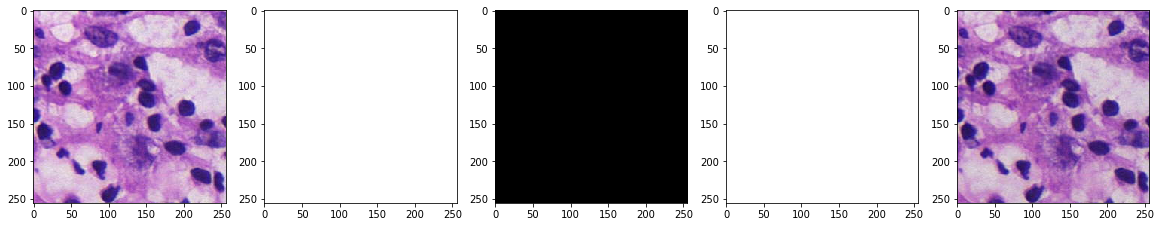

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import *

img = example_X[9:]

fig, ax = plt.subplots(1, 5, figsize=(20, 10))
ax = ax.ravel()
ax[0].imshow(img[0])
ax[1].imshow(next(ImageDataGenerator().flow(img))[0])
ax[2].imshow(next(ImageDataGenerator(brightness_range=(0., 0.)).flow(img))[0])
ax[3].imshow(next(ImageDataGenerator(brightness_range=(1., 1.)).flow(img))[0])
ax[4].imshow(next(ImageDataGenerator(brightness_range=(0.25, 1.)).flow(img))[0] / 255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


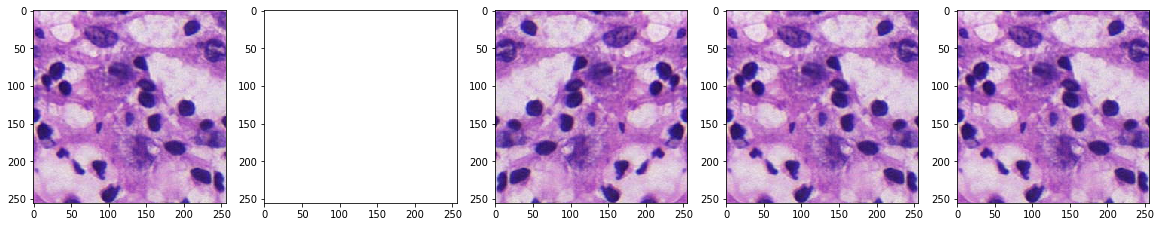

In [68]:
img = example_X[9:]

fig, ax = plt.subplots(1, 5, figsize=(20, 10))
ax = ax.ravel()
ax[0].imshow(img[0])
ax[1].imshow(next(ImageDataGenerator().flow(img))[0])
ax[2].imshow(next(ImageDataGenerator(horizontal_flip=True).flow(img))[0]/255)
ax[3].imshow(next(ImageDataGenerator(vertical_flip=True).flow(img))[0]/255)
ax[4].imshow(next(ImageDataGenerator(horizontal_flip=True,vertical_flip=True).flow(img))[0]/255)

# 좋은거 알아냈다. 

- Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
- ImageDataGenerator() 의 return datatype 은 float라는것도

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


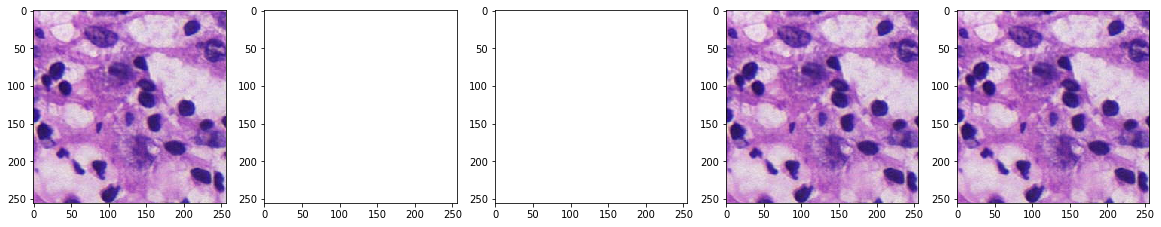

In [76]:
img = example_X[9:]

fig, ax = plt.subplots(1, 5, figsize=(20, 10))
ax = ax.ravel()
ax[0].imshow(img[0])
b = next(ImageDataGenerator().flow(img))
ax[1].imshow(b[0])
c = next(ImageDataGenerator(horizontal_flip=True).flow(img))
ax[2].imshow(c[0])
ax[3].imshow(next(ImageDataGenerator(vertical_flip=True).flow(img))[0]/255)
ax[4].imshow(next(ImageDataGenerator(horizontal_flip=True,vertical_flip=True).flow(img))[0]/255)

In [117]:
for i in range(60):
    next(ImageDataGenerator(horizontal_flip=True).flow(img)).shape

In [118]:
next(ImageDataGenerator(horizontal_flip=True).flow(img)).shape

(1, 500, 500, 3)

In [86]:
type(img[0,0,0,0])

numpy.uint8

In [85]:
type(b[0,0,0,0])

numpy.float32

In [79]:
img == b

array([[[[ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         ...,
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True]],

        [[ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         ...,
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True]],

        [[ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         ...,
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True]],

        ...,

        [[ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         ...,
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True]],

        [[ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         ...,
         [ True,  True,  True],
         [ T

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


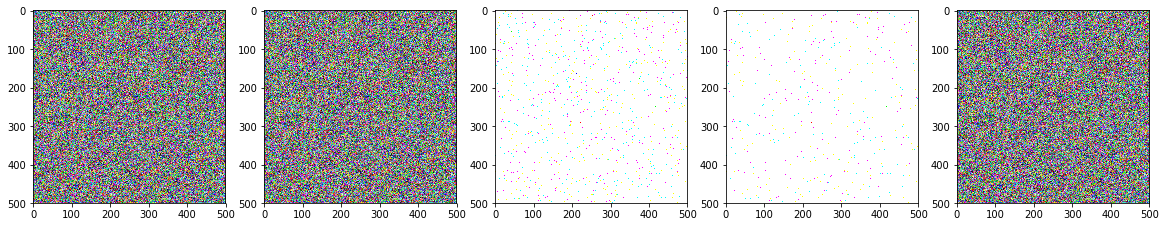

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import *

img = np.random.rand(1, 500, 500, 3)

fig, ax = plt.subplots(1, 5, figsize=(20, 10))
ax = ax.ravel()
ax[0].imshow(img[0])
ax[1].imshow(next(ImageDataGenerator().flow(img))[0])
ax[2].imshow(next(ImageDataGenerator(brightness_range=(0.5, 0.6)).flow(img))[0])
ax[3].imshow(next(ImageDataGenerator(brightness_range=(1., 1.)).flow(img))[0])
ax[4].imshow(next(ImageDataGenerator(brightness_range=(1., 1.)).flow(img))[0] / 255)

In [93]:
a = ImageDataGenerator(brightness_range=(1., 1.)).flow(img)

In [97]:
b = ImageDataGenerator(brightness_range=(0.5, 0.6)).flow(img)
b[0]

array([[[[ 59.,  12.,   1.],
         [112., 122.,  29.],
         [ 14.,  31.,  96.],
         ...,
         [ 41.,  64.,  14.],
         [ 47., 106.,  84.],
         [ 43., 119.,  32.]],

        [[100., 112.,   7.],
         [ 97.,  87.,  94.],
         [ 87., 123., 102.],
         ...,
         [  8.,  59.,  93.],
         [ 23.,  10.,  47.],
         [ 94., 109.,  90.]],

        [[ 60.,  23.,  87.],
         [126.,  23.,  13.],
         [ 97., 106., 117.],
         ...,
         [ 40.,  36., 116.],
         [ 85., 119.,   6.],
         [120., 101.,  27.]],

        ...,

        [[ 74.,  75., 101.],
         [ 48.,  74., 102.],
         [119., 105.,  80.],
         ...,
         [121.,  20.,   4.],
         [ 62.,  83.,   6.],
         [ 15.,  58.,  99.]],

        [[ 19., 121.,  99.],
         [ 60.,  66.,  10.],
         [ 45.,  70.,  12.],
         ...,
         [108.,  93., 100.],
         [ 12.,  80.,  14.],
         [ 95.,  19.,  11.]],

        [[ 88.,  97., 126.],
       

In [95]:
a[0]

array([[[[163., 195., 219.],
         [127., 134., 230.],
         [ 16., 106., 116.],
         ...,
         [128.,  85., 216.],
         [ 43., 127., 192.],
         [  7.,  27.,  10.]],

        [[121., 129.,  88.],
         [ 42., 225., 191.],
         [  8.,  11.,  84.],
         ...,
         [206., 141., 136.],
         [ 68.,  15., 124.],
         [240., 153.,  43.]],

        [[ 36.,  78.,  29.],
         [102., 212., 109.],
         [ 94.,  63., 218.],
         ...,
         [122.,  60., 215.],
         [123., 223.,  64.],
         [248.,   9., 250.]],

        ...,

        [[ 55.,  97., 184.],
         [170.,  97., 213.],
         [ 98., 179.,  66.],
         ...,
         [117.,  22.,  67.],
         [218., 206.,  73.],
         [157., 113.,  84.]],

        [[239., 194., 228.],
         [  2., 135.,  66.],
         [  9., 232.,  36.],
         ...,
         [ 37., 103., 251.],
         [224., 152., 170.],
         [139., 180., 105.]],

        [[ 16., 184., 107.],
       